In [2]:
import os
import re
import sqlite3

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Database connection using sqlite 3

In [32]:
db_path = 'database.sqlite'
con = sqlite3.connect(db_path)

### 1a) test db connection with a simple sql statement
**NOTE**: used string formatting to save potential typing later on

In [21]:
# base sql string
sql_base_select = 'SELECT {} FROM {};'

# format sql string
sql = sql_base_select.format('*', 'league')

# run select statement and show results
leagues = pd.read_sql(sql, con)
leagues.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [55]:
# how many leagues exists in db and which leagues are they
print(leagues['name'].nunique())
list(leagues['name'].unique()) # cast to list for "prettier" formatting than pd.Series object

11


['Belgium Jupiler League',
 'England Premier League',
 'France Ligue 1',
 'Germany 1. Bundesliga',
 'Italy Serie A',
 'Netherlands Eredivisie',
 'Poland Ekstraklasa',
 'Portugal Liga ZON Sagres',
 'Scotland Premier League',
 'Spain LIGA BBVA',
 'Switzerland Super League']

### 1b-1) using a **subquery** to *only* select premier league matches
**NOTE**: this avoids needing to find the league id before running the query, you just need to know a *unique* component of the league name which we can figure out from the list we printed above

In [10]:
sql = '''
    SELECT * FROM match
    WHERE league_id = (
        SELECT id from league
        WHERE name LIKE "%England%"
    );
'''

df = pd.read_sql(sql, con)
print('shape', df.shape)
df.head()

shape (3040, 115)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


### 1b-2) using a **join** to *only* select premier league matches
**NOTE**: same *rows* as above, just extra columns due to using a *different* method

**NOTE**: we could limit the columns to be the same as the subquery result if required

In [11]:
sql = '''
    SELECT * FROM match AS m
    JOIN League AS l
        ON m.league_id = l.id
    JOIN Country AS c
        ON m.country_id = c.id
    WHERE c.name = "England";
'''

df = pd.read_sql(sql, con)
print('shape', df.shape)
df.head()

shape (3040, 120)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBD,GBA,BSH,BSD,BSA,id,country_id,name,id,name
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,4.75,10.0,1.29,4.50,11.00,1729,1729,England Premier League,1729,England
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,5.50,13.0,1.22,5.00,13.00,1729,1729,England Premier League,1729,England
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,3.40,1.7,4.50,3.40,1.73,1729,1729,England Premier League,1729,England
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.25,4.0,1.91,3.25,3.80,1729,1729,England Premier League,1729,England
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.25,4.0,1.91,3.30,3.75,1729,1729,England Premier League,1729,England


In [13]:
df = pd.read_sql('SELECT * FROM match', con)
df.shape

(25979, 115)

## 2) how do team attributes and match stats vary across leagues/countries
The "Team" and "Team_attributes" tables do not have a direct link to country, we will create an augmented "Team" table that has a column for *league id* by creating a **view** this allows us to link teams to leagues **without** having to go through the **match** table

In [35]:
sql = '''
    CREATE VIEW IF NOT EXISTS Team_agumented AS
        SELECT DISTINCT l.id AS league_id, t.*
        FROM Match AS m
        JOIN League AS l
            ON m.league_id = l.id
        JOIN Team AS t
            ON m.home_team_api_id = t.team_api_id;
'''

con.execute(sql)
con.commit()

In [36]:
df = pd.read_sql('SELECT * FROM Team_agumented', con)
df.head()

,league_id,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,1,9987,673.0,KRC Genk,GEN
1,1,3,10000,15005.0,SV Zulte-Waregem,ZUL
2,1,5,9984,1750.0,KSV Cercle Brugge,CEB
3,1,7,9991,674.0,KAA Gent,GEN
4,1,9,7947,NaN,FCV Dender EH,DEN


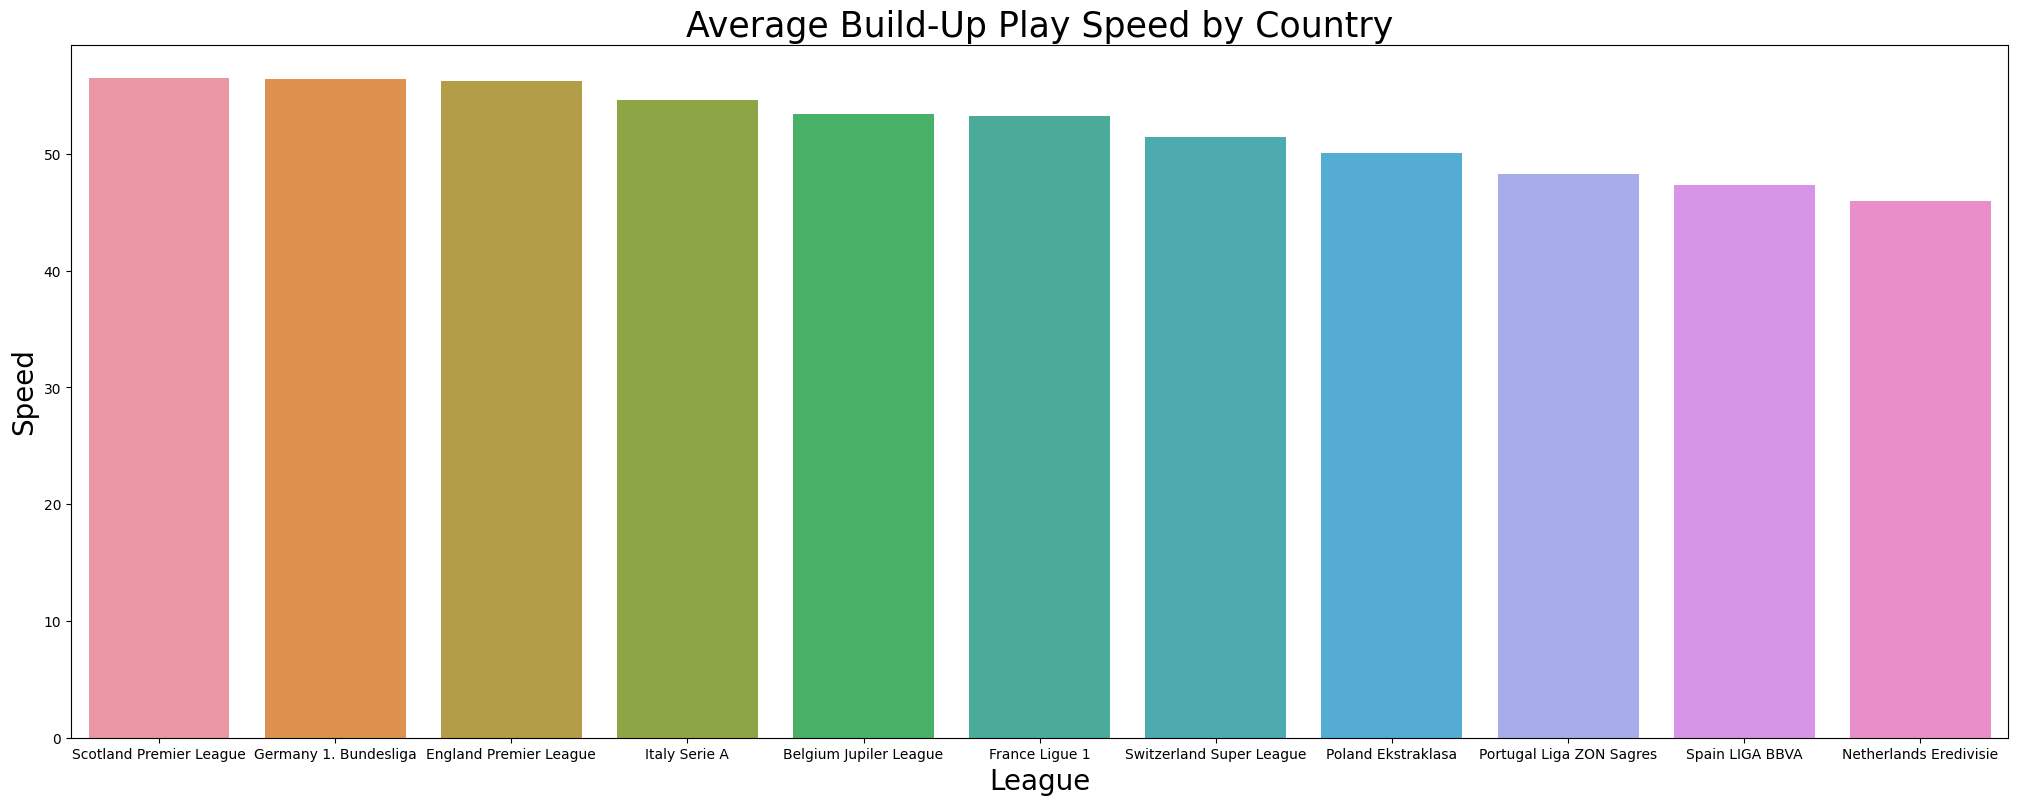

In [69]:
sql = '''
    SELECT l.name, AVG(buildUpPlaySpeed) AS avg_build_up_play_speed
    FROM Team_Attributes AS tat
    JOIN Team_agumented AS tau
        ON tat.team_api_id = tau.team_api_id
    JOIN league AS l
        ON tau.league_id = l.id
    GROUP BY league_id
    ORDER BY avg_build_up_play_speed DESC;
'''

df = pd.read_sql(sql, con)

fig = plt.figure(figsize=(25,9))
sns.barplot(df, x='name', y='avg_build_up_play_speed')
plt.title('Average Build-Up Play Speed by Country', fontsize=25)
plt.ylabel('Speed', fontsize=20)
plt.xlabel('League', fontsize=20)
plt.show()

In [40]:
sql = '''
    SELECT l.name, AVG(buildUpPlaySpeed) AS avg_build_up_play_speed
    FROM Team_Attributes AS tat
    JOIN Team_agumented AS tau
        ON tat.team_api_id = tau.team_api_id
    JOIN league AS l
        ON tau.league_id = l.id
    GROUP BY league_id
    ORDER BY avg_build_up_play_speed DESC;
'''

df = pd.read_sql(sql, con)

fig = plt.figure(figsize=(25,9))
sns.barplot(df, x='name', y='avg_build_up_play_speed')
plt.title('Average Build-Up Play Speed by Country', fontsize=25)
plt.ylabel('Speed', fontsize=20)
plt.xlabel('League', fontsize=20)
plt.show()

,name,"ROUND(AVG(buildUpPlaySpeed), 2)"
0,Belgium Jupiler League,53.39
1,England Premier League,56.21
2,France Ligue 1,53.21
3,Germany 1. Bundesliga,56.42
4,Italy Serie A,54.63
5,Netherlands Eredivisie,45.96
6,Poland Ekstraklasa,50.08
7,Portugal Liga ZON Sagres,48.28
8,Scotland Premier League,56.53
9,Spain LIGA BBVA,47.37


In [31]:
# close db connection
con.close()